In [12]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

FAST_MODEL = True

CSV_DIR = '../results/gpu'
all_files = [os.path.join(CSV_DIR, file) for file in os.listdir(CSV_DIR)]
df_list = [pd.read_csv(file) for file in all_files]
df = pd.concat(df_list, ignore_index=True)

df = df.loc[df['3mm'] == FAST_MODEL]
df['rank_factor'] = df['rank_factor'].astype(str).astype('category')
df['rank_factor'] = df['rank_factor'].cat.add_categories(['Original'])
df.loc[df['apply_tucker'] == False, 'rank_factor'] = 'Original'
new_order = ['Original', '0.9', '0.7', '0.5', '0.4', '0.3', '0.2', '0.1', '0.05']
df['rank_factor'] = df['rank_factor'].cat.reorder_categories(new_order, ordered=True)

df['device_name'] = df['device_name'].astype('category')
new_labels = {
    'NVIDIA GeForce RTX 3090': 'RTX 3090', 
    'NVIDIA GeForce GTX 1080': 'GTX 1080', 
    'NVIDIA A100-SXM4-40GB': 'A100', 
    'NVIDIA GeForce RTX 3060': 'RTX 3060', 
    'NVIDIA GeForce GTX 1660': 'GTX 1660', 
    'NVIDIA RTX A6000': 'A6000', 
    'GeForce RTX 2080 Ti': 'RTX 2080 Ti', 
    'NVIDIA GeForce RTX 2070 SUPER': 'RTX 2070 SUPER', 
}
df['device_name'] = df['device_name'].cat.rename_categories(new_labels)
new_order = ['GTX 1080', 'GTX 1660', 'RTX 2070 SUPER', 'RTX 2080 Ti', 'RTX 3060', 'RTX 3090', 'A6000', 'A100']
df['device_name'] = df['device_name'].cat.reorder_categories(new_order, ordered=True)

df.head()

,batch_size,device,load_params,apply_tucker,autocast,compile,eval_passes,ckpt_path,save_model,load_model,...,rank_mode,rank_factor,rank_min,decompose,verbose,g_flops,m_params,exec_time_mean,exec_time_std,device_name
0,1,cuda,False,True,True,True,10,.checkpoints/model.ckpt,False,False,...,relative,0.05,8,False,False,19.544361,0.151435,12.743056,0.117014,RTX 3090
2,1,cuda,False,True,True,False,10,.checkpoints/model.ckpt,False,False,...,relative,0.05,8,False,False,19.544361,0.151435,17.694096,0.094993,RTX 3090
4,1,cuda,False,True,False,True,10,.checkpoints/model.ckpt,False,False,...,relative,0.05,8,False,False,19.544361,0.151435,17.489190,0.097548,RTX 3090
6,1,cuda,False,True,False,False,10,.checkpoints/model.ckpt,False,False,...,relative,0.05,8,False,False,19.544361,0.151435,23.235347,0.021547,RTX 3090
8,1,cuda,False,False,True,True,10,.checkpoints/model.ckpt,False,False,...,relative,Original,8,False,False,369.144079,16.550518,22.564531,0.262672,RTX 3090


### GPU Variations

In [13]:
df['device_name'].unique()

['RTX 3090', 'GTX 1080', 'A100', 'RTX 3060', 'GTX 1660', 'A6000', 'RTX 2080 Ti', 'RTX 2070 SUPER']
Categories (8, object): ['GTX 1080' < 'GTX 1660' < 'RTX 2070 SUPER' < 'RTX 2080 Ti' < 'RTX 3060' < 'RTX 3090' < 'A6000' < 'A100']

### Maximum Batch Size

In [14]:
df_sub = df[df['compile'] == False]
df_batch = df_sub.groupby(['device_name', 'autocast', 'rank_factor'], observed=True)['batch_size'].max()
df_batch = df_batch.reset_index()

df_batch.head()

,device_name,autocast,rank_factor,batch_size
0,GTX 1080,False,Original,3
1,GTX 1080,False,0.9,2
2,GTX 1080,False,0.7,3
3,GTX 1080,False,0.5,3
4,GTX 1080,False,0.4,3


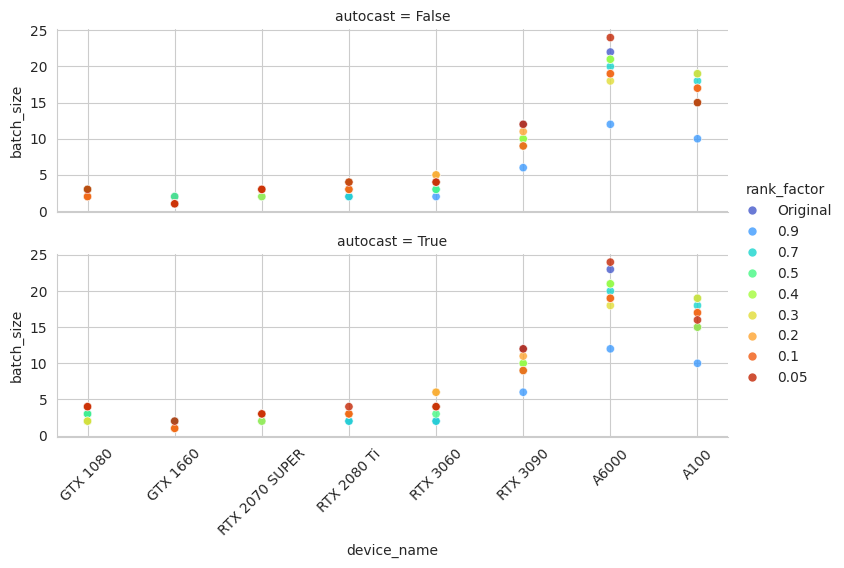

In [15]:
g = sns.relplot(
    data=df_batch,
    x='device_name',
    y='batch_size',
    hue='rank_factor',
    row='autocast',
    palette='turbo',
    alpha=0.8,
    height=2.5,
    aspect=3,
)

plt.xticks(rotation=45)
plt.show()

### Execution times

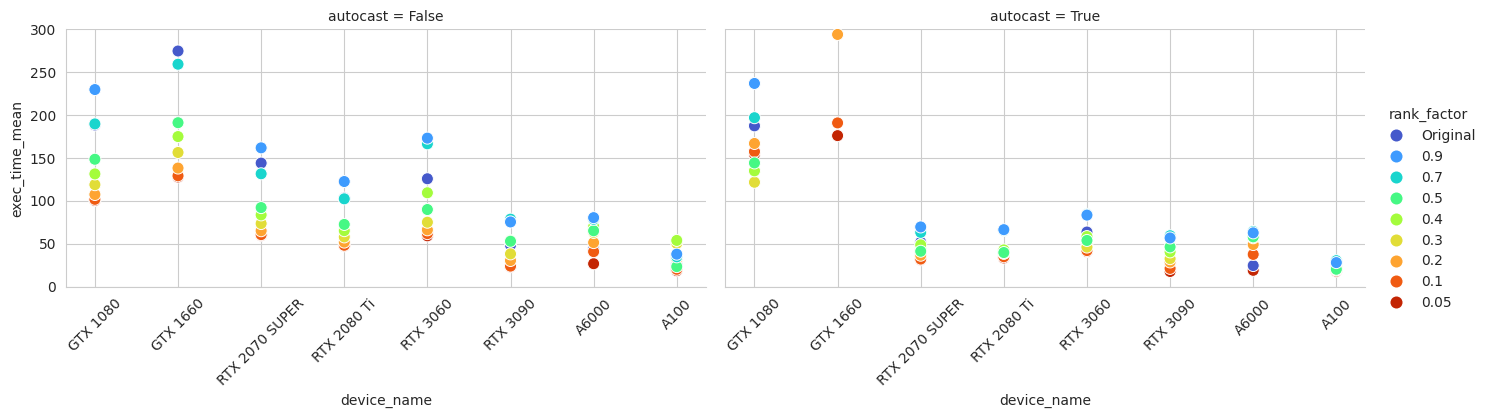

In [16]:
df_sub = df[df['batch_size'] == 1]
df_sub = df_sub[df_sub['compile'] == False]

g = sns.relplot(
    data=df_sub,
    x='device_name',
    y='exec_time_mean',
    hue='rank_factor',
    col='autocast',
    palette='turbo',
    alpha=1,
    height=3.5,
    aspect=2,
    s=75
)

g.set(ylim=(0, 300))

for ax in g.axes.flatten():
    ax.set_xticks(range(len(new_order)))
    ax.set_xticklabels(labels=new_order, rotation=45)
    
plt.show()

In [17]:
df_sub['exec_time_print'] = df_sub.apply(lambda row: f"{row['exec_time_mean']:.2f} $\pm$ {row['exec_time_std']:.2f}", axis=1)

print(df_sub.columns)
print(df_sub.head())
print(len(df_sub))

Index(['batch_size', 'device', 'load_params', 'apply_tucker', 'autocast',
       'compile', 'eval_passes', 'ckpt_path', 'save_model', 'load_model',
       '3mm', 'patch_size', 'nnunet_path', 'rank_mode', 'rank_factor',
       'rank_min', 'decompose', 'verbose', 'g_flops', 'm_params',
       'exec_time_mean', 'exec_time_std', 'device_name', 'exec_time_print'],
      dtype='object')
     batch_size device  load_params  apply_tucker  autocast  compile  \
2             1   cuda        False          True      True    False   
6             1   cuda        False          True     False    False   
10            1   cuda        False         False      True    False   
14            1   cuda        False         False     False    False   
159           1   cuda        False          True      True    False   

     eval_passes                ckpt_path  save_model  load_model  ...  \
2             10  .checkpoints/model.ckpt       False       False  ...   
6             10  .checkpoints/mode

In [18]:
pivot_df = df_sub.pivot_table(index=['autocast', 'rank_factor'], 
                        columns='device_name', 
                        values='exec_time_print',
                        aggfunc=lambda x: ' '.join(x)
).reset_index()

print(pivot_df.head())
pivot_df.to_latex('gpu_bench.tex', index=False)

device_name  autocast rank_factor           GTX 1080           GTX 1660  \
0               False    Original  188.37 $\pm$ 1.39  274.67 $\pm$ 0.39   
1               False         0.9  229.73 $\pm$ 0.82  312.37 $\pm$ 0.31   
2               False         0.7  189.69 $\pm$ 0.63  259.26 $\pm$ 0.34   
3               False         0.5  148.51 $\pm$ 0.25  191.10 $\pm$ 0.45   
4               False         0.4  131.40 $\pm$ 0.13  174.94 $\pm$ 0.27   

device_name     RTX 2070 SUPER        RTX 2080 Ti           RTX 3060  \
0            144.02 $\pm$ 0.26  103.24 $\pm$ 0.41  125.77 $\pm$ 0.41   
1            161.80 $\pm$ 0.33  122.53 $\pm$ 0.29  173.12 $\pm$ 0.23   
2            131.54 $\pm$ 0.26  102.35 $\pm$ 0.19  166.50 $\pm$ 0.28   
3             92.17 $\pm$ 0.14   72.52 $\pm$ 0.14   89.91 $\pm$ 1.48   
4             83.65 $\pm$ 0.09   65.28 $\pm$ 0.23  109.43 $\pm$ 1.48   

device_name          RTX 3090             A6000              A100  
0            48.35 $\pm$ 0.07  44.22 $\pm$ 0.19 

/tmp/ipykernel_5591/3207908652.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df_sub.pivot_table(index=['autocast', 'rank_factor'],
